<a href="https://colab.research.google.com/github/Jeongchan-Kim/CRISPR-Repair-Outcome-Prediction/blob/main/CRISPR_Repair_Outcome_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyTDC
!pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.0 MB/s eta 0:00:00
  Created wheel for PyTDC: filename=PyTDC-0.4.0-py3-none-any.whl size=139536 sha256=1322c4154ed9df61c797e04625f017aa6338d6ee9a521b16927fef184338e40b
  Stored in directory: /root/.cache/pip/wheels/65/da/1a/38e66a2b950c7acc0f41d3bbbc12071653d099baa5402d9c32
Successfully built PyTDC


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 10.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=896b78a15fd6ba324515326162a40cdd2f5378c39946ca8c224c15c666cbc6e3
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('Leenay')

In [ ]:
from tdc.single_pred import CRISPROutcome
data = CRISPROutcome(name = 'Leenay', label_name = label_list[0])
split = data.get_split()

Downloading...
100%|██████████| 205k/205k [00:00<00:00, 1.13MiB/s]
Loading...
Done!


# **Data Preprocessing & Torch Dataloader**

In [ ]:
import torch
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

class SeqProcessor:
    def __init__(self, char, max_seq):
        # One-hot encoding에 사용할 character 정의
        self.char = char
        #  ㅒne-hot 인코더 fitting
        self.enc_dna = OneHotEncoder().fit(np.array(self.char).reshape(-1, 1))
        # Sequence 최대 길이
        self.max_seq = max_seq

    def trans_dna(self, x: str) -> list:
        temp = list(x.upper()) # 대문자로 바꾸기
        temp = [i if i in self.char else '?' for i in temp] # 

        if len(temp) < self.max_seq:
            # MAX_SEQ_DNA 보다 작으면 뒷부분을 ?로 채워서 MAX_SEQ_DRUG 길이의 리스트로 만들기
            temp = temp + ['?'] * (self.max_seq-len(temp))
        else:
            # MAX_SEQ_DNA 보다 크면 앞에서부터 MAX_SEQ_DRUG 만큼 슬라이싱
            temp = temp [:self.max_seq]

        return temp

    def dna_2_embed(self, x: list) -> np.ndarray:
        return self.enc_dna.transform(np.array(x).reshape(-1,1)).toarray().T

In [ ]:
# Custom dataset
class data_process_loader(Dataset):
    def __init__(self, df: pd.DataFrame, sp: SeqProcessor):
        self.sp = sp
        self.df = df

    def __len__(self):
        return self.df.shape[0] 

    def __getitem__(self, index):
      
        # Target data
        v_s = self.df.iloc[index]['GuideSeq'] 
        v_s = self.sp.trans_dna(v_s)
        v_s = self.sp.dna_2_embed(v_s) # Target One-hot 인코딩 [26,100]

        # Binding affinity (label)
        y = self.df.iloc[index]['Y'] 

        return v_s, y

In [ ]:
# defince processor for dna sequence
dna_char=['?', 'A', 'T', 'G', 'C']
max_seq=23

sp = SeqProcessor(dna_char, max_seq)

In [ ]:
train_dataset = data_process_loader(split["train"], sp)
valid_dataset = data_process_loader(split["valid"], sp)
test_dataset = data_process_loader(split["test"], sp)

In [ ]:
# DataLoader을 위한 hyperparameter 설정

params = {'batch_size': 64,
        'shuffle': True,
        'num_workers': 1,
        'drop_last': False}

training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(valid_dataset, **params)
test_generator = DataLoader(test_dataset, **params)

In [ ]:
# Dataloader 확인해보기 

for (v_s, y) in training_generator:
    print(v_s.shape)
    print(y)
    break

torch.Size([64, 5, 23])
tensor([0.0789, 0.1993, 0.1052, 0.3236, 0.0899, 0.0066, 0.0278, 0.1108, 0.1398,
        0.0556, 0.0531, 0.2569, 0.0929, 0.0601, 0.4545, 0.0771, 0.0809, 0.1233,
        0.2842, 0.0388, 0.1143, 0.3063, 0.2950, 0.1004, 0.2738, 0.0037, 0.2920,
        0.2970, 0.0249, 0.0131, 0.2198, 0.1494, 0.7208, 0.1319, 0.2231, 0.6214,
        0.3218, 0.2509, 0.3028, 0.0583, 0.1469, 0.0845, 0.4152, 0.3048, 0.0889,
        0.3860, 0.0624, 0.2658, 0.2983, 0.1173, 0.1763, 0.2841, 0.1427, 0.1000,
        0.0889, 0.5233, 0.0608, 0.1484, 0.4071, 0.1335, 0.2339, 0.0696, 0.0673,
        0.1364], dtype=torch.float64)


In [ ]:
# Dataloader 확인해보기 

for (v_s, y) in valid_generator:
    print(v_s.shape)
    print(y)
    break

torch.Size([64, 5, 23])
tensor([0.2522, 0.4093, 0.5262, 0.2433, 0.3253, 0.1223, 0.1805, 0.0687, 0.0733,
        0.0631, 0.0917, 0.0612, 0.2276, 0.1248, 0.2652, 0.0976, 0.2934, 0.1239,
        0.4746, 0.0538, 0.3341, 0.1921, 0.0361, 0.0843, 0.0723, 0.1251, 0.0435,
        0.4459, 0.3644, 0.0632, 0.3225, 0.1412, 0.1273, 0.2350, 0.1782, 0.0556,
        0.0956, 0.2063, 0.5707, 0.0946, 0.2985, 0.2589, 0.1542, 0.0610, 0.5727,
        0.0917, 0.0644, 0.0237, 0.0705, 0.3938, 0.1185, 0.2976, 0.3425, 0.2021,
        0.2721, 0.5188, 0.0374, 0.0086, 0.2473, 0.0663, 0.0206, 0.0215, 0.4433,
        0.4273], dtype=torch.float64)


In [ ]:
# Dataloader 확인해보기 

for (v_s, y) in test_generator:
    print(v_s.shape)
    print(y)
    break

torch.Size([64, 5, 23])
tensor([0.0958, 0.1062, 0.3271, 0.1235, 0.0770, 0.1661, 0.0701, 0.3123, 0.1094,
        0.2332, 0.5810, 0.0831, 0.1410, 0.2731, 0.3959, 0.2999, 0.3162, 0.0547,
        0.0335, 0.0263, 0.2337, 0.0553, 0.3538, 0.1086, 0.6788, 0.2960, 0.5051,
        0.0987, 0.5152, 0.1005, 0.2310, 0.1310, 0.2407, 0.6917, 0.1908, 0.0708,
        0.0395, 0.0862, 0.0849, 0.1891, 0.0417, 0.2939, 0.2291, 0.2316, 0.2586,
        0.2338, 0.5444, 0.4620, 0.4818, 0.0822, 0.1633, 0.4433, 0.2864, 0.4761,
        0.1424, 0.3966, 0.2224, 0.3097, 0.2496, 0.1214, 0.2021, 0.0763, 0.0586,
        0.4338], dtype=torch.float64)


# **MODEL**

In [ ]:
# Hyperparameter

config = {
    # dna embedding layer 설정
    "cnn_filters" : [32,64,96],
    "cnn_kernels" : [3,3,3],
    "hidden_dim" : 256,
    "rnn_hid_dim" : 64,
    "rnn_n_layers" : 2,
    "rnn_bidirectional" : True,
    "rnn_Use_GRU_LSTM" : 'GRU',

    # Classfier 설정
    "cls_hidden_dims" : [1024, 512]
    }

In [ ]:
class CNN_RNN(nn.Sequential):

    def __init__(self, **config):
        super(CNN_RNN, self).__init__()
        self.config = config
        """
        CNN 구현 
        """
        # 레이어 별 CNN 필터 개수 
        in_ch = [5] + config['cnn_filters']
        self.in_ch = in_ch[-1] # 마지막 convolution 층 필터 개수

        # 레이어 별 CNN kernel 사이즈
        kernels = config['cnn_kernels']

        # 전체 CNN Layer 개수
        layer_size = len(config['cnn_filters'])

        self.conv = nn.ModuleList([nn.Conv1d(in_channels = in_ch[i], # input 채널 수
                                                out_channels = in_ch[i+1], # output 채널 수
                                                kernel_size = kernels[i]) for i in range(layer_size)]) # kernel 사이즈
        self.conv = self.conv.double()

        # 마지막 층 사이즈 구하기
        n_size_d = self._get_conv_output((5, 23)) # auto get the seq_len of CNN output

        """
        RNN 구현 (LSTM / GRU)
        """
        if config['rnn_Use_GRU_LSTM'] == 'LSTM':
            self.rnn = nn.LSTM(input_size = in_ch[-1], # input feature 사이즈 (convolution 이 후 채널 개수)
                            hidden_size = config['rnn_hid_dim'], # hidden feature 사이즈
                            num_layers = config['rnn_n_layers'], # recurrent layer 개수
                            batch_first = True, # If True, (batch, seq, feature) Else, (seq, batch, feature)
                            bidirectional = config['rnn_bidirectional']) # If True, Bidirectional LSTM
        
        elif config['rnn_Use_GRU_LSTM'] == 'GRU':
            self.rnn = nn.GRU(input_size = in_ch[-1], # input feature 사이즈 (convolution 이 후 채널 개수)
                            hidden_size = config['rnn_hid_dim'], # hidden feature 사이즈
                            num_layers = config['rnn_n_layers'], # recurrent layer 개수
                            batch_first = True, # If True, (batch, seq, feature) Else, (seq, batch, feature
                            bidirectional = config['rnn_bidirectional']) # If True, Bidirectional LSTM
        else:
            raise AttributeError('Please use LSTM or GRU.')

        direction = 2 if config['rnn_bidirectional'] else 1
        self.rnn = self.rnn.double()

        # 마지막 drug 임베딩 층
        self.fc1 = nn.Linear(config['rnn_hid_dim'] * direction * n_size_d, config['hidden_dim'])

    def _get_conv_output(self, shape):
        
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input.double())
        n_size = output_feat.data.view(bs, self.in_ch, -1).size(2)
        return n_size

    def _forward_features(self, x):
        for l in self.conv:
            x = F.relu(l(x))
        return x

    def forward(self, v):
        v = self._forward_features(v.double())
  
        batch_size = v.size(0)
        v = v.view(batch_size, v.size(2), -1) 

        if self.config['rnn_Use_GRU_LSTM'] == 'LSTM':
            direction = 2 if self.config['rnn_bidirectional'] else 1
            h0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize hidden state
            c0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize cell state
            v, (hn, cn) = self.rnn(v.double(), (h0.double(), c0.double()))
        else:
            # GRU
            direction = 2 if self.config['rnn_bidirectional'] else 1
            h0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device)
            v, hn = self.rnn(v.double(), h0.double())

        v = torch.flatten(v, 1)
        v = self.fc1(v.float())
        return v

In [ ]:
class Classifier(nn.Sequential):
	def __init__(self, model_dna, **config):

		super(Classifier, self).__init__()

		self.input_dim = config['hidden_dim'] # drug feature 사이즈

		self.model_dna = model_dna # drug 임베딩 모델

		self.dropout = nn.Dropout(0.1) # dropout 적용

		self.hidden_dims = config['cls_hidden_dims'] # classifier hidden dimensions
		layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
		dims = [self.input_dim] + self.hidden_dims + [1] # ["합쳐진 feature 차원 (drug + protein), hidden1, hidden2, hidden3, 1 (output layer)] 
		
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifer layers 

	def forward(self, v_s):
		# Drug/protein 임베딩
		v_s = self.model_dna(v_s)
  
		for i, l in enumerate(self.predictor):
			if i == (len(self.predictor)-1):
				# If last layer,
				v_s = l(v_s)
			else:
				# If Not last layer, dropout과 ReLU 적용
				v_s = F.relu(self.dropout(l(v_s)))
	
		return v_s

# **MODEL Training**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [ ]:
# model for drug
model_dna = CNN_RNN(**config)

# classifier
model = Classifier(model_dna, **config)

model = model.to(device) 

In [ ]:
# Hyperparameter 

learning_rate = 0.0001
decay         = 0.00001
train_epoch   = 30

In [ ]:
# optimizer 

opt      = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)
loss_fn = torch.nn.MSELoss()

# **Training**

In [ ]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index

In [ ]:
loss_history = []

max_MSE = 10000


# Best 모델 초기화
model_max = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"] 
valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기 

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록 
t_start = time() 

for epo in range(train_epoch):
    # Model training 
    model.train()
    
    # Mini-batch 학습 
    for i, (v_s, label) in enumerate(training_generator):
        # input data gpu에 올리기 
        v_s = v_s.float().to(device) 
        # forward-pass
        score = model(v_s) 

        n = torch.squeeze(score, 1)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
        loss = loss_fn(n.float(), label.float().to(device))

        # 각 iteration 마다 loss 기록 
        loss_history.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()
    
    # gradient tracking X
    with torch.set_grad_enabled(False):
        
        y_pred = []
        y_label = []
        # model validation
        model.eval()

        for i, (v_s, label) in enumerate(valid_generator):
            # validation 입력 데이터 gpu에 올리기
            v_s = v_s.float().to(device)

            # forward-pass
            score = model(v_s)

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            logits = torch.squeeze(score).cpu().numpy()
            label_ids = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label_ids.flatten().tolist()
            y_pred = y_pred + logits.flatten().tolist()
    
    # metric 계산
    mse = mean_squared_error(y_label, y_pred) # MSE 
    r2 = pearsonr(y_label, y_pred)[0] # Pearson correlation coefficient
    p_val = pearsonr(y_label, y_pred)[1] # Pearson correlation p-value
    CI =  concordance_index(y_label, y_pred) # CI 

    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)
    
    # mse 기준으로 best model 업데이트
    if mse < max_MSE:
        # best model deepcopy 
        model_max = copy.deepcopy(model)
        # max MSE 업데이트 
        max_MSE = mse

    # 각 epoch 마다 결과 출력 
    print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

--- Go for Training ---
Validation at Epoch 1 , MSE: 0.02501 , Pearson Correlation: 0.10154 with p-value: 2.13E-01 , Concordance Index: 0.51516
Validation at Epoch 2 , MSE: 0.02508 , Pearson Correlation: 0.11372 with p-value: 1.63E-01 , Concordance Index: 0.53424
Validation at Epoch 3 , MSE: 0.02550 , Pearson Correlation: -0.0356 with p-value: 6.63E-01 , Concordance Index: 0.49468
Validation at Epoch 4 , MSE: 0.02536 , Pearson Correlation: 0.05929 with p-value: 4.68E-01 , Concordance Index: 0.50941
Validation at Epoch 5 , MSE: 0.02585 , Pearson Correlation: 0.00516 with p-value: 9.50E-01 , Concordance Index: 0.50113
Validation at Epoch 6 , MSE: 0.02530 , Pearson Correlation: 0.02844 with p-value: 7.28E-01 , Concordance Index: 0.50287
Validation at Epoch 7 , MSE: 0.02545 , Pearson Correlation: -0.0132 with p-value: 8.71E-01 , Concordance Index: 0.47324
Validation at Epoch 8 , MSE: 0.02462 , Pearson Correlation: 0.17737 with p-value: 2.88E-02 , Concordance Index: 0.56369
Validation at Ep

In [ ]:
# Test 진행할 데이터 확인 
for i, (v_d, label) in enumerate(test_dataset):
    print(v_d)
    print(label)
    break

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]]
0.1766602192134107


# **TEST**

In [ ]:
y_pred = []
y_label = []

model.eval()
for i, (v_s, label) in enumerate(test_generator):
    # input data gpu에 올리기 
    v_s = v_s.float().to(device)

    # forward-pass
    score = model(v_s)

    # 예측값 gradient graph detach -> cpu로 옮기기 -> numpy 형으로 변환 
    logits = torch.squeeze(score).detach().cpu().numpy()

    # 참값 cpu로 옮기고 numpy 형으로 변환 
    label_ids = label.cpu().numpy()

    # 예측값, 참값 기록
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()

# metric 계산
mse = mean_squared_error(y_label, y_pred)
r2 = pearsonr(y_label, y_pred)[0]
p_val = pearsonr(y_label, y_pred)[1]
CI =  concordance_index(y_label, y_pred)

print('TestSet Performence Metric '+  ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
        + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

TestSet Performence Metric  , MSE: 0.01012 , Pearson Correlation: 0.75650 with p-value: 1.21E-57 , Concordance Index: 0.78115


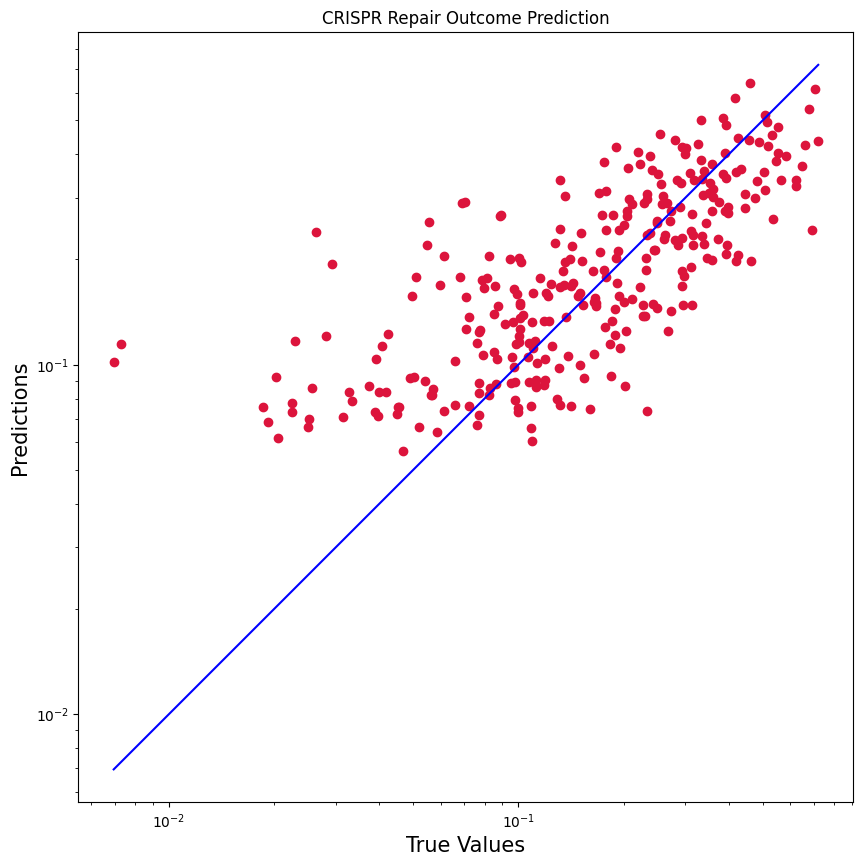

In [ ]:
# 최종 테스트 결과 시각화 
import matplotlib.pyplot as plt

# 참값 ~ 예측값 scatter plot 
plt.figure(figsize=(10,10))
plt.scatter(y_label, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_label))
p2 = min(min(y_pred), min(y_label))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('CRISPR Repair Outcome Prediction')
plt.show()